# Running a Vanilla Variational Autoencoder on the MIMIC-III Dataset

In [1]:
# Adapted from https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
os.environ["KERAS_BACKEND"] = "tensorflow"  # Rather than Torch, for example

import keras
from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from keras.models import Model, Sequential
from keras.objectives import binary_crossentropy
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping
import keras.backend as K
import random
import scipy
from scipy.stats import norm
from scipy.stats import multivariate_normal
import sklearn
from sklearn import model_selection
import tensorflow as tf

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Reading in the Data

In [2]:
# Read in the data, make sure it's numeric
X = pd.read_csv("milestone_cohort.csv")
X = X.iloc[:,4:]  # We don't include the patient, hospital, or ICU stay ID's because they're meaningless in this context

### Splitting into a train/test fold

In [3]:
# Set the train/test size
X_train, X_test = sklearn.model_selection.train_test_split(X, train_size=0.8)

# Convert your inputs to numpy arrays (Keras doesn't play nice with pandas dataframes)
X_train = np.array(X_train)
X_test = np.array(X_test)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### Training a decoder, generator and decoder+generator VAE on the dataset

In [4]:
def evaluate_vae_model(X_train, X_test, latent_dimensions, intermediate_dimensions):
    
    #Hyperparameters of interest
    intermediate_dim = intermediate_dimensions
    latent_dim = latent_dimensions
    
    # Other hyperparameters
    original_dim = X_test.shape[1]  # Calculated automatically
    batch_size = X_test.shape[0]  # This might affect the learning rate, but shouldn't affect the overall model outcome
    n_epochs = 10  # Not as important when we use the early stopping method (as we do in this method)
    epsilon_std = 1.0  # This shouldn't significantly change the model performance, as the z_log_sigma will adjust to accommodate
    
    # The Encoder, from the original data to the latent dimensions
    inputs = Input(shape=(original_dim,))
    hidden = Dense(intermediate_dim, activation='relu')(inputs)
    z_mean = Dense(latent_dim, activation='linear')(hidden)
    z_log_sigma = Dense(latent_dim, activation='linear')(hidden)
    
    # The sampler
    def sample_z(args):
        z_mean, z_log_sigma = args
        eps = K.random_normal(shape=(K.shape(inputs)[0], latent_dim),
                             mean=0., stddev=1.)
        return z_mean + K.exp(z_log_sigma / 2) * eps  # Element-wise product of SD with gaussian noise, + mean vector

    z = Lambda(sample_z, output_shape=(latent_dim,))([z_mean, z_log_sigma])
    
    # The Decoder
    decoder_h = Dense(intermediate_dim, activation='relu')  # We don't specify the inputs because we'll use...
    decoder_mean = Dense(original_dim, activation='linear')  # ...the same layers again for the generator model below
    decoder_log_sigma = Dense(original_dim, activation='linear')
    h_decoded = decoder_h(z)
    output_decoded_mean = decoder_mean(h_decoded)  # Our output is a mean vector (point estimate) and...
    output_decoded_log_sigma = decoder_log_sigma(h_decoded)  # ...a log_sigma, or log_variance vector...
                                                            # which quantifies our certainty about the point estimate
        
    # The end-to-end autoencoder
    vae = Model(inputs, output_decoded_mean)

    # An encoder, from inputs to the latent space
    encoder = Model(inputs, z_mean)

    # A generator, from the latent space to the reconstructed inputs
    generator_input = Input(shape=(latent_dim,))
    generator_h_decoded = decoder_h(generator_input)
    generator_output_decoded_mean = decoder_mean(generator_h_decoded)
    generator_output_decoded_log_sigma = decoder_log_sigma(generator_h_decoded)
    generator = Model(generator_input, [generator_output_decoded_mean, generator_output_decoded_log_sigma])
    
    def vae_loss(y_true, y_pred):
        """ Calculate loss = reconstruction loss + KL loss for each data in minibatch """
        # -E[log P(X|z)]    
        reconstruction_loss = neg_log_likelihood(y_true, y_pred)

        # D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
        kl_loss = KL_divergence_loss(y_true, y_pred)

        return reconstruction_loss + kl_loss

    def neg_log_likelihood(y_true, y_pred):
        """ Calculate a proper negative log-likelihood where NLL = -log p(y_pred | mu=y_true, sigma=output_decoded_log_sigma)"""
        negative_log_likelihood = (1./2.) * \
                        (
                            K.int_shape(inputs)[1] * K.log(2. * np.pi) + \
                            K.sum(output_decoded_log_sigma, axis=-1, keepdims=True) + \
                            K.sum(
                                K.square(y_true - y_pred) * (1. / K.exp(output_decoded_log_sigma)), 
                                axis=-1, keepdims=True
                            )
                        )
        return negative_log_likelihood
    
    # An alternative loss function... should give similar results as the above, but isn't a proper NLL per-se
    def squared_difference_loss(y_true, y_pred):
        """ Calculate a naive reconstruction loss, i.e. ||y_true - y_pred||^2 """
        return K.sum(K.square(y_true - y_pred), axis=-1)  # TODO! This isn't strictly speaking the NLL, but it's a half decent approximation for now

    def KL_divergence_loss(y_true, y_pred):
        """ Calculate the KL Divergence portion of the loss, i.e. D_KL(Q(z|X) || P(z|X)) """
        return 0.5 * K.sum(K.exp(z_log_sigma) + K.square(z_mean) - 1. - z_log_sigma, axis=-1)

    vae.compile(optimizer='rmsprop', 
                loss=vae_loss, 
                metrics=[squared_difference_loss, 
                         KL_divergence_loss, 
                         neg_log_likelihood
                        ]
               )

    # define an early stopping callback criterion so that we don't overfit
    earlystop = keras.callbacks.EarlyStopping(monitor='val_loss',  # The quantity to be monitored
                                             min_delta=0.0001,  # Minimum change in the monitored quantity in order to qualify
                                                                # as an improvement (if an absolute change of less than min_delta occurs,
                                                                # will not count as no improvement)
                                             patience=10,  # The number of epochs with no improvement after which training will be stopped
                                             verbose=0,  # Verbosity mode
                                             mode='min')  # Training will stop when the quantity monitored has stopped decreasing
    
    callbacks_list = [earlystop]
    
    history = vae.fit(X_train,
                      X_train,
                      shuffle=True,
                      epochs=n_epochs,
                      verbose=1,
                      batch_size=batch_size,
                      callbacks=callbacks_list,
                      validation_split=0.3)
    
    X_test_encoded = encoder.predict(X_test)  # We take our test data directly from data-space to latent variable
    X_test_decoded_mean, X_test_decoded_log_sigma = generator.predict(X_test_encoded)  # space to calculate the
    # marginal log likelihood of the data under our fully-trained model (i.e. we don't add noise)
    test_nll = (1./2.) * \
               (
                   X_test.shape[1] * np.log(2. * np.pi) + \
                   np.sum(X_test_decoded_log_sigma, axis=-1, keepdims=True) + \
                   np.sum(
                       np.square(X_test - X_test_decoded_mean) * (1. / np.exp(X_test_decoded_log_sigma)), 
                       axis=-1, keepdims=True
                   )
               )
    
    return np.mean(test_nll), vae, encoder, generator, history

In [5]:
n_z = 4 # Number of units in the latent variable representation
n_h = 50 # Number of hidden units in encoder/decoder
test_err, vae, encoder, generator, history = evaluate_vae_model(X_train, X_test, n_z, n_h)

Train on 29507 samples, validate on 12647 samples
Epoch 1/10
29507/29507 [==============================] - 7s 236us/step - loss: 485189.9360 - squared_difference_loss: 24.6833 - KL_divergence_loss: 1.3829 - neg_log_likelihood: 485198.5810 - val_loss: 38.1729 - val_squared_difference_loss: 24.3814 - val_KL_divergence_loss: 1.3478 - val_neg_log_likelihood: 36.8252
Epoch 2/10
29507/29507 [==============================] - 7s 230us/step - loss: 37.3406 - squared_difference_loss: 23.9301 - KL_divergence_loss: 1.2577 - neg_log_likelihood: 36.0829 - val_loss: 40.6560 - val_squared_difference_loss: 24.0429 - val_KL_divergence_loss: 1.2730 - val_neg_log_likelihood: 39.3830
Epoch 3/10
29507/29507 [==============================] - 7s 230us/step - loss: 37.5090 - squared_difference_loss: 23.6031 - KL_divergence_loss: 1.1983 - neg_log_likelihood: 36.3106 - val_loss: 36.8190 - val_squared_difference_loss: 23.7288 - val_KL_divergence_loss: 1.2271 - val_neg_log_likelihood: 35.5919
Epoch 4/10
29507/2

### Plot the Train Loss & Validation Loss vs. Number of Epochs to see our model's performance

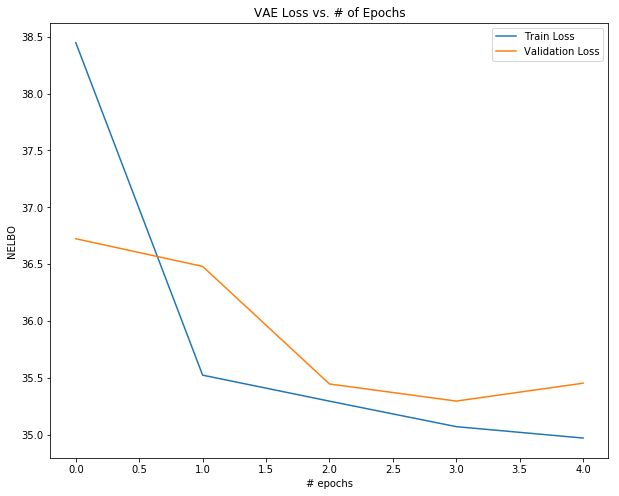

In [6]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(history.history['loss'][5:], label='Train Loss')
ax.plot(history.history['val_loss'][5:], label='Validation Loss')

ax.legend()


ax.set_ylabel('NELBO')
ax.set_xlabel('# epochs')

plt.title('VAE Loss vs. # of Epochs')
plt.show()

### Examining the relationship between the latent variables and the original variables

In [7]:
names = list(X.columns)
n_examples = 20000

old_pats = X_train[:n_examples]
zvals = encoder.predict(old_pats)
# get some known patients.
min_z = -3
max_z = 3
skip = 1

latent_vars = {}
latent_var_spectra = {}

for i in range(n_z):  # For each latent variable...
    latent_name = "z" + str(i)
    latent_vars[latent_name] = {}
    latent_var_spectra[latent_name] = np.zeros(len(names))
    layer = latent_vars[latent_name]
    for z in range(min_z, max_z, skip):  # ...fix the value of the latent variable (for a suite of values)
        zvals[:, i] = z
        new_pats = generator.predict(zvals)  # new_pats[0] is mu_x, new_pats[1] is sigma^2_x
        new_z = np.ones(n_examples) * z
        if "x" in layer:
            layer["x"] = np.concatenate((layer["x"], new_pats[0]))
        else:
            layer["x"] = new_pats[0]
        if "z" in layer:
            layer["z"] = np.concatenate((layer["z"], new_z), axis=0)
        else:
            layer["z"] = new_z
    # Take the correlation between the latent variable and all other original data variables,
    # we'll call this the latent variable's "fingerprint" or "spectrum" and we want to compare the different latent vars
    for j, real_varname in enumerate(names):
        latent_var_spectra[latent_name][j] = np.corrcoef(latent_vars[latent_name]['z'], latent_vars[latent_name]['x'][:, j])[0, 1]

In [14]:
latent_vars[latent_name]['z']

array([-3., -3., -3., ...,  2.,  2.,  2.])

### Calculate the top n absolute value correlations for each latent variable

In [12]:
n = 3
for i in range(n_z):
    latent_name = "z" + str(i)
    print('\nTop {} associated variables for Latent Variable {}:'.format(n, latent_name))
    top_n_associated_indxs = np.argsort(np.abs(latent_var_spectra[latent_name]))[::-1][:n]
    for association in zip(np.array(names)[top_n_associated_indxs], 
                           latent_var_spectra[latent_name][top_n_associated_indxs]):
        print(association)


Top 3 associated variables for Latent Variable z0:
('meanBilirubin', -0.8812279825962345)
('meanSodium', -0.8511106848514706)
('meanSysBP', 0.8172884902243519)

Top 3 associated variables for Latent Variable z1:
('meanHR', -0.9514668184678677)
('maxNumSIRSCrit', 0.951285685226018)
('meanChloride', 0.9446769129762191)

Top 3 associated variables for Latent Variable z2:
('maxNumSIRSCrit', -0.9823717358631493)
('meanPT', -0.9781134899401537)
('meanBilirubin', -0.9751389774811301)

Top 3 associated variables for Latent Variable z3:
('meanChloride', 0.9986500362941128)
('meanPotassium', 0.9962625327939053)
('meanAlbumin', 0.9956203247630435)


### Plot the correlation 'spectra' for each latent variable vs. the original variables

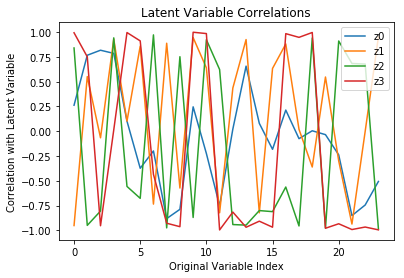

In [9]:
for i in range(n_z):  # For each latent variable...
    plt.plot(latent_var_spectra["z" + str(i)], label="z" + str(i))
plt.xlabel('Original Variable Index')
plt.ylabel('Correlation with Latent Variable')
plt.title('Latent Variable Correlations')
plt.legend(loc='upper right')
plt.show()

### Plot the relationship between the latent variables and the original variables across all samples (see milestone for figures)

KeyboardInterrupt: 

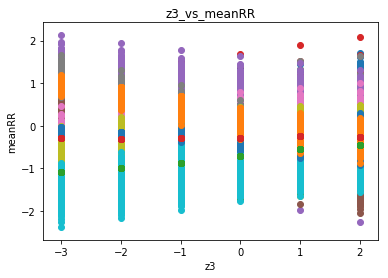

In [10]:
# plot each latent variable against each real value
x_z_data = []  # {x: xvals, z: zvals, varname}
fignum = 0
for z_i in range(n_z):
    latent_varname = "z" + str(z_i)
    for j, real_varname in enumerate(names):
        fignum += 1
        title = latent_varname + "_vs_" + real_varname
        x_data = latent_vars[latent_varname]["x"][:,j]
        z_data = latent_vars[latent_varname]["z"]

        plt.scatter(z_data, x_data)  # we control the hidden var, z.
        plt.title(title)
        plt.xlabel(latent_varname)
        plt.ylabel(real_varname)
        plt.savefig("figures/title"+".png")

### A Note on the Generator...

In [ ]:
# This function is deterministic...
for i in range(10):
    print(np.mean(np.sum(np.square(X_test - generator.predict(encoder.predict(X_test))), axis=1)))

In [ ]:
# ...but this function is stochastic
for i in range(10):
    print(np.mean(np.sum(np.square(X_test - vae.predict(X_test)), axis=1)))

## Grid Search to get the right number of hidden variables (Not yet implemented)

In [ ]:
from sklearn.model_selection import KFold
X = pd.read_csv("milestone_cohort.csv")
X = X.drop(['participant_id'], axis=1)
X = X.set_index(['subNum'])
X_mat = np.array(X)

n_folds = 5
num_latent_vars = [5, 10, 15, 20, 25, 30, 50, 75, 100, 150, 250, 500, 1000]
num_hidden_vars = [10, 25, 50, 100, 250, 500, 750, 1000, 1500, 2500, 5000]
cv_results = pd.DataFrame(0,
                           index=num_latent_vars,
                           columns=num_hidden_vars)

kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
kf.get_n_splits(X_mat)

i = 1
for lat_var_num in num_latent_vars:
    for hid_var_num in num_hidden_vars:
        fold_num = 1
        total_nll = 0.
        
        print('Simulation #{}: VAE with {} Latent Variable(s) and {} Hidden Variable(s)...'.format(i, lat_var_num, hid_var_num))
        
        for train_index, test_index in kf.split(X_mat):
            X_train, X_test = X_mat[train_index], X_mat[test_index]
            print("\tEvaluating model on Fold {}".format(fold_num))
            total_nll += evaluate_vae_model(X_train, 
                                            X_test, 
                                            latent_dimensions=lat_var_num, 
                                            intermediate_dimensions=hid_var_num)
            fold_num += 1

        cv_results.loc[lat_var_num, hid_var_num] = total_nll / n_folds
        print('\tAvgerage Negative Log-Likelihood = {}'.format(total_nll / n_folds))
        i += 1

In [ ]:
import seaborn as sns
sns.heatmap(-my_cv_results)
plt.xlabel('# Hidden Layer Variables')
plt.ylabel('# Latent Variables')
plt.show()

### A comparison with PCA and Factor Analysis, after SciKit Learn's http://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_fa_model_selection.html#sphx-glr-auto-examples-decomposition-plot-pca-vs-fa-model-selection-py (In Progress)

In [ ]:
from sklearn.decomposition import PCA
num_simulations = 10
num_latent_vars = range(1, 51)
pca_sim_results = pd.DataFrame(0, 
                           index=range(1, num_simulations * len(num_latent_vars) + 1), 
                           columns=['simulation', 
                                    'num_latent_vars', 
                                    'squared_error'])

i = 0
for lat_var_num in num_latent_vars:
    for sim_num in range(1, num_simulations + 1):
        X_train, X_test = sklearn.model_selection.train_test_split(X, train_size = 0.7)
        pca_model = PCA(n_components=lat_var_num)
        pca_model.fit(X_train)
        X_test_pca = pca_model.transform(X_test)
        X_test_pca_estimate = pca_model.inverse_transform(X_test_pca)
        recon_err = np.mean(np.sum(np.square(X_test - X_test_pca_estimate), axis=1))
        
        print('Simulation #{} VAE with {} Latent Variable(s)...'.format(sim_num, lat_var_num))

        pca_sim_results.iloc[i, :] = [sim_num, 
                                      lat_var_num,
                                      recon_err]
        i += 1

In [ ]:
# http://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_fa_model_selection.html#sphx-glr-auto-examples-decomposition-plot-pca-vs-fa-model-selection-py

import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.covariance import ShrunkCovariance, LedoitWolf
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

print(__doc__)

# #############################################################################
# Fit the models

n_components = np.arange(1, 50, 1)  # options for n_components

def compute_scores(X):
    pca = PCA(svd_solver='full')
    fa = FactorAnalysis()

    pca_scores, fa_scores = [], []
    for n in n_components:
        if n % 10 == 0:
            print ("Running PCA/FA for {} Components...".format(n))
        pca.n_components = n
        fa.n_components = n
        pca_scores.append(np.mean(cross_val_score(pca, X))) # Return the average log-likelihood of all samples.
        fa_scores.append(np.mean(cross_val_score(fa, X))) # Return the average log-likelihood of all samples.

    return pca_scores, fa_scores

def shrunk_cov_score(X):
    shrinkages = np.logspace(-2, 0, 30)
    cv = GridSearchCV(ShrunkCovariance(), {'shrinkage': shrinkages})
    return np.mean(cross_val_score(cv.fit(X).best_estimator_, X))

def lw_score(X):
    return np.mean(cross_val_score(LedoitWolf(), X))

pca_scores, fa_scores = compute_scores(X)
n_components_pca = n_components[np.argmax(pca_scores)]
n_components_fa = n_components[np.argmax(fa_scores)]

pca = PCA(svd_solver='full', n_components='mle')
pca.fit(X)
n_components_pca_mle = pca.n_components_

print("best n_components by PCA CV = %d" % n_components_pca)
print("best n_components by FactorAnalysis CV = %d" % n_components_fa)
print("best n_components by PCA MLE = %d" % n_components_pca_mle)

In [ ]:
plt.figure()

#plt.plot(num_latent_vars[:6], -cv_results.loc[num_latent_vars[:6],150], 'g', label='VAE scores')

plt.plot(n_components, pca_scores, 'b', label='PCA scores')
plt.axvline(n_components_pca, color='b',
            label='PCA CV: %d' % n_components_pca, linestyle='--')

plt.plot(n_components, fa_scores, 'r', label='FA scores')
plt.axvline(n_components_fa, color='r',
            label='FactorAnalysis CV: %d' % n_components_fa,
            linestyle='--')


plt.axhline(lw_score(X), color='orange',
            label='LedoitWolf MLE' % n_components_pca_mle, linestyle='-.')

plt.xlabel('Number of Components')
plt.ylabel('Log-Likelihood')
# plt.ylabel('CV scores')
plt.legend(loc='lower right')

plt.show()